In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.integrate import odeint
from scipy.optimize import least_squares
from scipy import optimize
from datetime import date, timedelta
import random

state_dic={'AC': 'Acre',
 'AL': 'Alagoas',
 'AP': 'Amapá',
 'AM': 'Amazonas',
 'BA': 'Bahia',
 'CE': 'Ceará',
 'DF': 'Federal District',
 'ES': 'Espírito Santo',
 'GO': 'Goiás',
 'MA': 'Maranhão',
 'MT': 'Mato Grosso',
 'MS': 'Mato Grosso do Sul',
 'MG': 'Minas Gerais',
 'PA': 'Pará',
 'PB': 'Paraíba',
 'PR': 'Paraná',
 'PE': 'Pernambuco',
 'PI': 'Piauí',
 'RJ': 'Rio de Janeiro',
 'RN': 'Rio Grande do Norte',
 'RS': 'Rio Grande do Sul',
 'RO': 'Rondônia',
 'RR': 'Roraima',
 'SC': 'Santa Catarina',
 'SP': 'São Paulo',
 'SE': 'Sergipe',
 'TO': 'Tocantins'}


def beta(t,b0,b1,t1):
    if t<=t1:
        beta=b0
    if t>t1:
        beta=b1
    return beta

def SIR(f,t,parametros):
    #parameters
    b0,b1,t1, g = parametros
    #variables
    S = f[0]
    I = f[1]
    R = f[2]
    Nc = f[3]
    #equations inclunding epidemic curve
    dS_dt = -beta(t,b0,b1,t1)*S*I/N
    dI_dt = beta(t,b0,b1,t1)*S*I/N - g*I 
    dR_dt = g*I

    
    #new cases rate
    dNc_dt = beta(t,b0,b1,t1)*S*I/N
    
    return [dS_dt,dI_dt,dR_dt,dNc_dt]


def lq_SIR(pars, ts0):
    b0, b1, t1, g, i0 = pars
    #initial conditions
    q0 = [N-i0,i0,0,0]
    #parameters
    parode = b0, b1, t1, g
    #calls integrator
    qs = odeint(SIR,q0, ts0,args=(parode,),mxstep=1000000)

    qi = qs[:,-1]
    #define the standardized residuals
    err = (qi - data) / np.sqrt(qi+1)
    return np.r_[err] 





def Best_Fit(data,n_tries):

    # #DEEFINE THE INTERVALS OF PARS
    intervals = np.array([ [0., 2.], #b0
                           [0., 2.] ,#b1
                           [15, 25],#t1
                           [1/14, 1/3], #g
                           [0, 25]   #i0
                           ])

    #NUMBER OF FITS

    #best error starts at inft 
    best_err = np.inf
    #aj the number of best fists 
    aj = 0

    for i in range(n_tries):
        
        
        #create a set of parameters in the interval
        par0 = np.random.rand(len(intervals))
        par0 = intervals[:,0] + par0 * (intervals[:,1] - intervals[:,0])
        #try to fit
        try:
            res = least_squares(lambda pars: lq_SIR(pars,ts0), par0, bounds=(intervals[:,0], \
                                                     intervals[:,1]))

            ier = res.status
            #if converges
            if ier >= 1 and ier <= 4:
                if res.cost < best_err:
                    #best_err = erro
                    best_err = res.cost
                    #best_pop = parametro
                    best_pop = res.x
                    #+1 best fit
                    aj = aj +1
                    print('achou',aj)
                    

            #in does not converge, do nothing
        except:pass

    return best_pop

achou 1
achou 2
achou 3
achou 4
achou 5


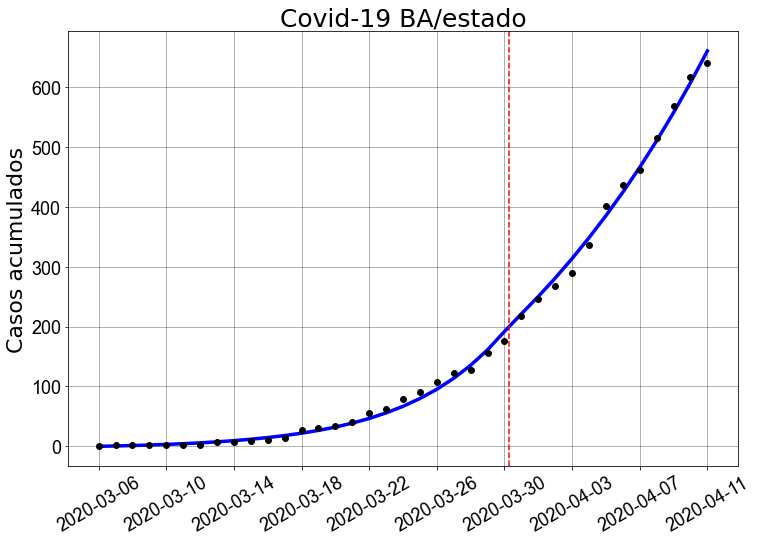

In [32]:
#Fitting the q-exp

#Define the state and the type of fit: (estado,capital,interior)
s='BA'
file='estado'

N=14873064

#Read csv
df=pd.read_csv('Data/'+s+"/"+file+".csv")

#Limit the date of the Fit
df = df.query("date <= '2020-04-11'")

#Read the file
dates=df.date.values
data=df.cases.values

#Run the minimizer
n_tries=25 #Quanto maior mais certeza do resultado. Colocar em 100 para roda com mais certeza (Ou até maiws se for necessário)
best_pop=Best_Fit(data,n_tries)

b0,b1,t1, g, i0=best_pop
#Create an x axixis for plotting the function.



q0 = [N-i0,i0,0,0]
    #parameters
parode = b0,b1,t1, g
#calls integrator
qs = odeint(SIR,q0, ts0,args=(parode,),mxstep=1000000)

qi = qs[:,-1] #Casos acumulados

ni= np.array([qs[:,-1][0]]+list(np.diff(qs[:,-1]))) #Novos Casos


#Plotting
#Create the figure and the graph.
fig, ax = pl.subplots(figsize=(12,8))

#Create a grid for visualization.
ax.grid(which='major', axis='both', color='black',linewidth=1.,alpha=0.3)

#Plot the points(Scatters). s=size, zorder= priority->(puttin g the points in at the front of everything).
ax.scatter(dates,data, s=35,color='black',zorder=3,label='Reported data')

#Plot the fitted function as a line.
ax.plot(dates,qi,color='blue', linewidth=3.5,label='Fitted function')


ax.axvline(t1, 0, 600,c='r',linestyle='--',label='Intervention')


#Set the labels
ax.set_ylabel('Casos acumulados',fontsize=22)

#Set the title
ax.set_title('Covid-19 '+s+'/'+file,fontsize=25)

#The size of the numbers on the axixis
ax.tick_params(labelsize=18)

#Limiting the ammount of dates on the X axixs
ax.xaxis.set_major_locator(pl.MaxNLocator(10))
#Rotating the dates for better visualization
pl.setp(ax.get_xticklabels(), rotation=30)


#Setting the font of the numbers on the axixis as ARIAL 
for tick in ax.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax.get_yticklabels():
    tick.set_fontname("Arial")  

#Show Graph       
pl.show()

#Save Fig
fig.savefig(r"Fits\\"+s+file+".png",bbox_inches='tight')

